In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafizhanurulqolby","key":"924c2b4d6798ddacd5b7dd25aca29e2d"}'}

In [2]:
import os
import zipfile

# Buat folder .kaggle di sistem
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d techsash/waste-classification-data
# Unzip
with zipfile.ZipFile("waste-classification-data.zip", 'r') as zip_ref:
    zip_ref.extractall("waste_dataset")

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0


In [3]:
os.listdir("waste_dataset")

['DATASET', 'dataset']

**Splitting Data**

In [4]:
#Dataset belum ada Data Validasi

import shutil
from sklearn.model_selection import train_test_split

# Path ke folder train dan folder val baru
train_dir = "/content/waste_dataset/DATASET/TRAIN"
val_dir = "/content/waste_dataset/val"
os.makedirs(val_dir, exist_ok=True)

# Loop tiap kelas di train
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    # Ambil 20% untuk validation
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    val_class_path = os.path.join(val_dir, class_name)
    os.makedirs(val_class_path, exist_ok=True)

    # Pindahkan file ke folder val
    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_path, img)
        shutil.move(src, dst)

print("✅ Validation set berhasil dibuat dari train set!")
print("Perbandingan Data Splitting 70:15:15")

✅ Validation set berhasil dibuat dari train set!
Perbandingan Data Splitting 70:15:15


In [5]:
#Memindahkan Dataset ke Direktori lebih tinggi

# Tentukan path sumber dan tujuan
source_train = '/content/waste_dataset/DATASET/TRAIN'
source_test = '/content/waste_dataset/DATASET/TEST'

# Tentukan tujuan folder baru di luar DATASET
dest_train = '/content/waste_dataset/train'
dest_test = '/content/waste_dataset/test'

# Pindahkan folder
shutil.move(source_train, dest_train)
shutil.move(source_test, dest_test)

print("✅ Folder 'train' dan 'test' berhasil dipindahkan ke luar 'DATASET'.")

✅ Folder 'train' dan 'test' berhasil dipindahkan ke luar 'DATASET'.


**Pre-Processing Data**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel ke rentang 0-1
    shear_range=0.2,  # Penggeseran gambar
    zoom_range=0.2,  # Zoom in/out gambar
    horizontal_flip=True  # Pembalikan horizontal gambar untuk augmentasi
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi di validation

# Direktori dataset (folder train dan val)
train_dir = '/content/waste_dataset/train'
val_dir = '/content/waste_dataset/val'

# Membaca data gambar dari direktori dan mempersiapkannya
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Ukuran gambar yang diinginkan (resize)
    batch_size=32,
    class_mode='categorical'  # Karena ini adalah klasifikasi lebih dari 2 kelas
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),  # Ukuran gambar yang diinginkan (resize)
    batch_size=32,
    class_mode='categorical'
)

Found 18051 images belonging to 2 classes.
Found 4513 images belonging to 2 classes.


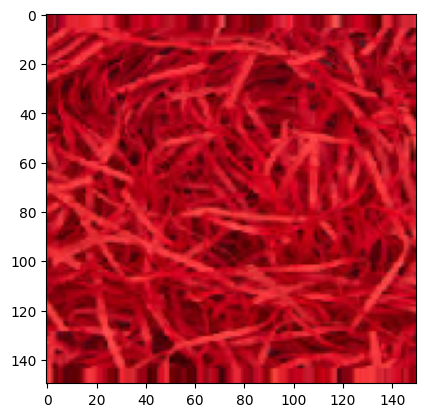

In [7]:
# Menampilkan beberapa gambar pertama dari train_generator
import matplotlib.pyplot as plt

# Ambil batch pertama dari train_generator
x_batch, y_batch = next(train_generator)

# Menampilkan gambar pertama dari batch
plt.imshow(x_batch[0])
plt.show()

**Modelling Data**

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Inisialisasi model Sequential
model = Sequential()

# Menambahkan layer Convolutional (Conv2D)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tambahkan lebih banyak layer convolutional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten untuk menyiapkan layer fully connected
model.add(Flatten())

# Menambahkan Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(2, activation='softmax')) # 2 kelas (organik dan non-recyclable)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile and Fit Model**

In [9]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7625 - loss: 0.5144

564/564 ━━━━━━━━━━━━━━━━━━━━ 1021s 2s/step - accuracy: 0.7625 - loss: 0.5143 - val_accuracy: 0.8338 - val_loss: 0.3826
Epoch 2/30
  1/564 ━━━━━━━━━━━━━━━━━━━━ 14:09 2s/step - accuracy: 0.8750 - loss: 0.3300

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


564/564 ━━━━━━━━━━━━━━━━━━━━ 74s 129ms/step - accuracy: 0.8750 - loss: 0.3300 - val_accuracy: 0.8309 - val_loss: 0.3864
Epoch 3/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.8337 - loss: 0.3975 - val_accuracy: 0.8349 - val_loss: 0.3871
Epoch 4/30
  1/564 ━━━━━━━━━━━━━━━━━━━━ 12:06 1s/step - accuracy: 0.7812 - loss: 0.5631

564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.7812 - loss: 0.5631 - val_accuracy: 0.8488 - val_loss: 0.3615
Epoch 5/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.8464 - loss: 0.3742 - val_accuracy: 0.8537 - val_loss: 0.3662
Epoch 6/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.9062 - loss: 0.2660 - val_accuracy: 0.8488 - val_loss: 0.3750
Epoch 7/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8591 - loss: 0.3553

564/564 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.8591 - loss: 0.3553 - val_accuracy: 0.8737 - val_loss: 0.3158
Epoch 8/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 114ms/step - accuracy: 0.9375 - loss: 0.2916 - val_accuracy: 0.8741 - val_loss: 0.3179
Epoch 9/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 1041s 2s/step - accuracy: 0.8662 - loss: 0.3336 - val_accuracy: 0.8659 - val_loss: 0.3434
Epoch 10/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 140ms/step - accuracy: 0.9062 - loss: 0.2879 - val_accuracy: 0.8573 - val_loss: 0.3665
Epoch 11/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8632 - loss: 0.3474

564/564 ━━━━━━━━━━━━━━━━━━━━ 971s 2s/step - accuracy: 0.8632 - loss: 0.3474 - val_accuracy: 0.8728 - val_loss: 0.3100
Epoch 12/30
  1/564 ━━━━━━━━━━━━━━━━━━━━ 11:50 1s/step - accuracy: 0.8750 - loss: 0.3058

564/564 ━━━━━━━━━━━━━━━━━━━━ 62s 108ms/step - accuracy: 0.8750 - loss: 0.3058 - val_accuracy: 0.8706 - val_loss: 0.3082
Epoch 13/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8711 - loss: 0.3138

564/564 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.8711 - loss: 0.3138 - val_accuracy: 0.8799 - val_loss: 0.2967
Epoch 14/30
  1/564 ━━━━━━━━━━━━━━━━━━━━ 12:14 1s/step - accuracy: 0.8438 - loss: 0.3223

564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.8438 - loss: 0.3223 - val_accuracy: 0.8834 - val_loss: 0.2960
Epoch 15/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.8789 - loss: 0.3014 - val_accuracy: 0.8801 - val_loss: 0.3050
Epoch 16/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - accuracy: 0.9062 - loss: 0.2765 - val_accuracy: 0.8797 - val_loss: 0.3056
Epoch 17/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 972s 2s/step - accuracy: 0.8794 - loss: 0.3025 - val_accuracy: 0.8845 - val_loss: 0.3053
Epoch 18/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 83s 144ms/step - accuracy: 1.0000 - loss: 0.1325 - val_accuracy: 0.8850 - val_loss: 0.3024
Epoch 19/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8839 - loss: 0.2865

564/564 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.8839 - loss: 0.2865 - val_accuracy: 0.8905 - val_loss: 0.2809
Epoch 20/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - accuracy: 0.8125 - loss: 0.3220 - val_accuracy: 0.8896 - val_loss: 0.2811
Epoch 21/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 976s 2s/step - accuracy: 0.8848 - loss: 0.2857 - val_accuracy: 0.8905 - val_loss: 0.2836
Epoch 22/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.8750 - loss: 0.4452 - val_accuracy: 0.8887 - val_loss: 0.2839
Epoch 23/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 1041s 2s/step - accuracy: 0.8882 - loss: 0.2748 - val_accuracy: 0.8794 - val_loss: 0.3070
Epoch 24/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 63s 110ms/step - accuracy: 0.7500 - loss: 0.7019 - val_accuracy: 0.8803 - val_loss: 0.3003
Epoch 25/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.8920 - loss: 0.2759 - val_accuracy: 0.8901 - val_loss: 0.2869
Epoch 26/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.9062 - loss: 0.3252 - v

**Evaluasi Model**

In [12]:
# Akurasi training dan validation
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training: {train_acc * 100:.2f}%")
print(f"Akurasi Validasi: {val_acc * 100:.2f}%")

Akurasi Training: 89.50%
Akurasi Validasi: 88.56%


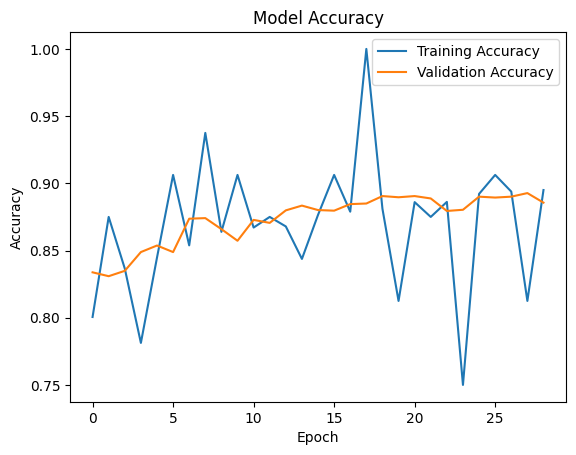

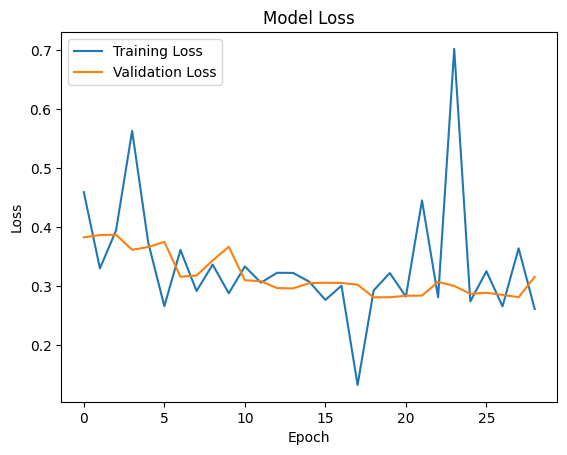

In [13]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Menyimpan Model**

In [14]:
#SavedModel
model.export("saved_model_waste")

Saved artifact at 'saved_model_waste'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135064520075856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520076048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520077776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520080848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520081040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520080464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064520079888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064499323344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135064499325264: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [15]:
#TF Lite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_waste")
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model_waste.tflite", "wb") as f:
    f.write(tflite_model)

In [17]:
# Bikin file label.txt
labels = ["organic", "non-recyclable"]

with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

print("✅ label.txt berhasil dibuat!")

✅ label.txt berhasil dibuat!


In [16]:
#TFJS
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model_waste tfjs_model_waste

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-26 12:22:17.386817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745670137.433748   74895 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174